In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
circuits = pd.read_csv("../data/circuits.csv")
constructors = pd.read_csv("../data/constructors.csv")
drivers = pd.read_csv("../data/drivers.csv")
qualification = pd.read_csv("../data/qualifying.csv")
races = pd.read_csv("../data/races.csv")
results = pd.read_csv("../data/results.csv")
seasons = pd.read_csv("../data/seasons.csv")

In [ ]:
#merge files

dataframe_1 = pd.merge(drivers,qualification,how='inner', on=['driverId'])
dataframe_2 = pd.merge(dataframe_1, results, how="inner", on =["driverId", "raceId", "constructorId"])
dataframe_3 = pd.merge(dataframe_2, constructors, how="inner", on=["constructorId"])
dataframe_4 = pd.merge(dataframe_3, races, how="inner", on=['raceId'])
dataframe_5 = pd.merge(dataframe_4, circuits, how="inner", on=["circuitId"])

In [ ]:
# print(dataframe_5.columns)
final_data = dataframe_5.drop(['number_x','url_x', 'qualifyId', 
       'number_y', 'q1', 'q2', 'q3', 'position_y', 'positionText', 'positionOrder', 
       'time_x', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'url_y', 'name_y', 'time_y', 'url_x',
       'lat', 'lng', 'alt', 'url_y'],axis=1)

In [288]:

final_data.rename(columns={'name':'GP_name','position_x':'position','name_x':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
# final_data.to_csv("data_merged.csv")

In [289]:
print(final_data.columns)
#changing the names of the constructors who have changed their team names
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)
# print(final_data["constructor"].unique())

Index(['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob',
       'driver_nationality', 'raceId', 'constructorId', 'position', 'resultId',
       'number', 'grid', 'points', 'laps', 'statusId', 'constructorRef',
       'constructor', 'constructor_nationality', 'year', 'round', 'circuitId',
       'date', 'circuitRef', 'GP_name', 'location', 'country', 'driver',
       'ageDuringRace', 'Drivers'],
      dtype='object')


In [294]:
#Driver name
final_data["driver"] = final_data["forename"] + final_data["surname"]

In [ ]:
#Calculating the age of driver during the race
final_data["dob"] = pd.to_datetime(final_data["dob"])
final_data["date"] = pd.to_datetime(final_data["date"])
final_data["ageDuringRace"] = abs(final_data["dob"] - final_data["date"])
final_data["ageDuringRace"] = final_data["ageDuringRace"].apply(lambda x: str(x).split(" ")[0])
final_data["ageDuringRace"] = final_data["ageDuringRace"].astype("int64") #changing to int type


In [319]:
age_vs_points = final_data[['driver', 'ageDuringRace', 'points']].copy()
age_vs_points.isnull().sum()
age_vs_points.dropna(inplace=True)

#converting to age
age_vs_points["ageDuringRace"] = age_vs_points["ageDuringRace"].apply(lambda age: age//365)

In [338]:
age_vs_points.to_csv("age_vs_points.csv")
# print(age_vs_points[age_vs_points["points"] == 50])

      Unnamed: 0         driver  ageDuringRace  points
7385        7385  LewisHamilton             29    50.0


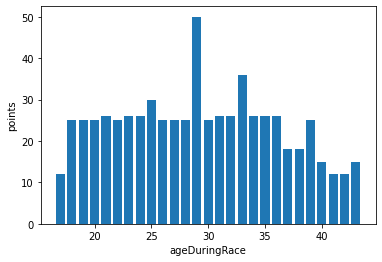

In [337]:
age_vs_points = pd.read_csv("age_vs_points.csv")

# plt.plot(age_vs_points.ageDuringRace, age_vs_points.points)
plt.bar(x=age_vs_points.ageDuringRace, height=age_vs_points.points)
plt.xlabel('ageDuringRace')
plt.ylabel("points")
plt.show()


In [ ]:
#scraping data for driver's height 

#Python program to scrape website 
#and save quotes from website
import requests
from bs4 import BeautifulSoup
import csv
   
URL = "https://racingnews365.com/2022-f1-drivers-height-and-weight"
r = requests.get(URL)
   
soup = BeautifulSoup(r.content, 'html.parser')
table_body = soup.findChildren("tbody")
print(table_body)
for row in table_body:
    cells = row